In [8]:
import pandas as pd

In [20]:
df = pd.read_csv(r'/home/karthik/Desktop/drowsiness_detection_project/drowsiness_data/drowsiness_dataset_cleaned.csv')

In [23]:
df.columns

Index(['window_id', 'perclos', 'eye_blink_rate', 'blink_duration',
       'yawning_rate', 'steering_entropy', 'steering_reversal_rate',
       'std_lane_position', 'drowsiness_level'],
      dtype='object')

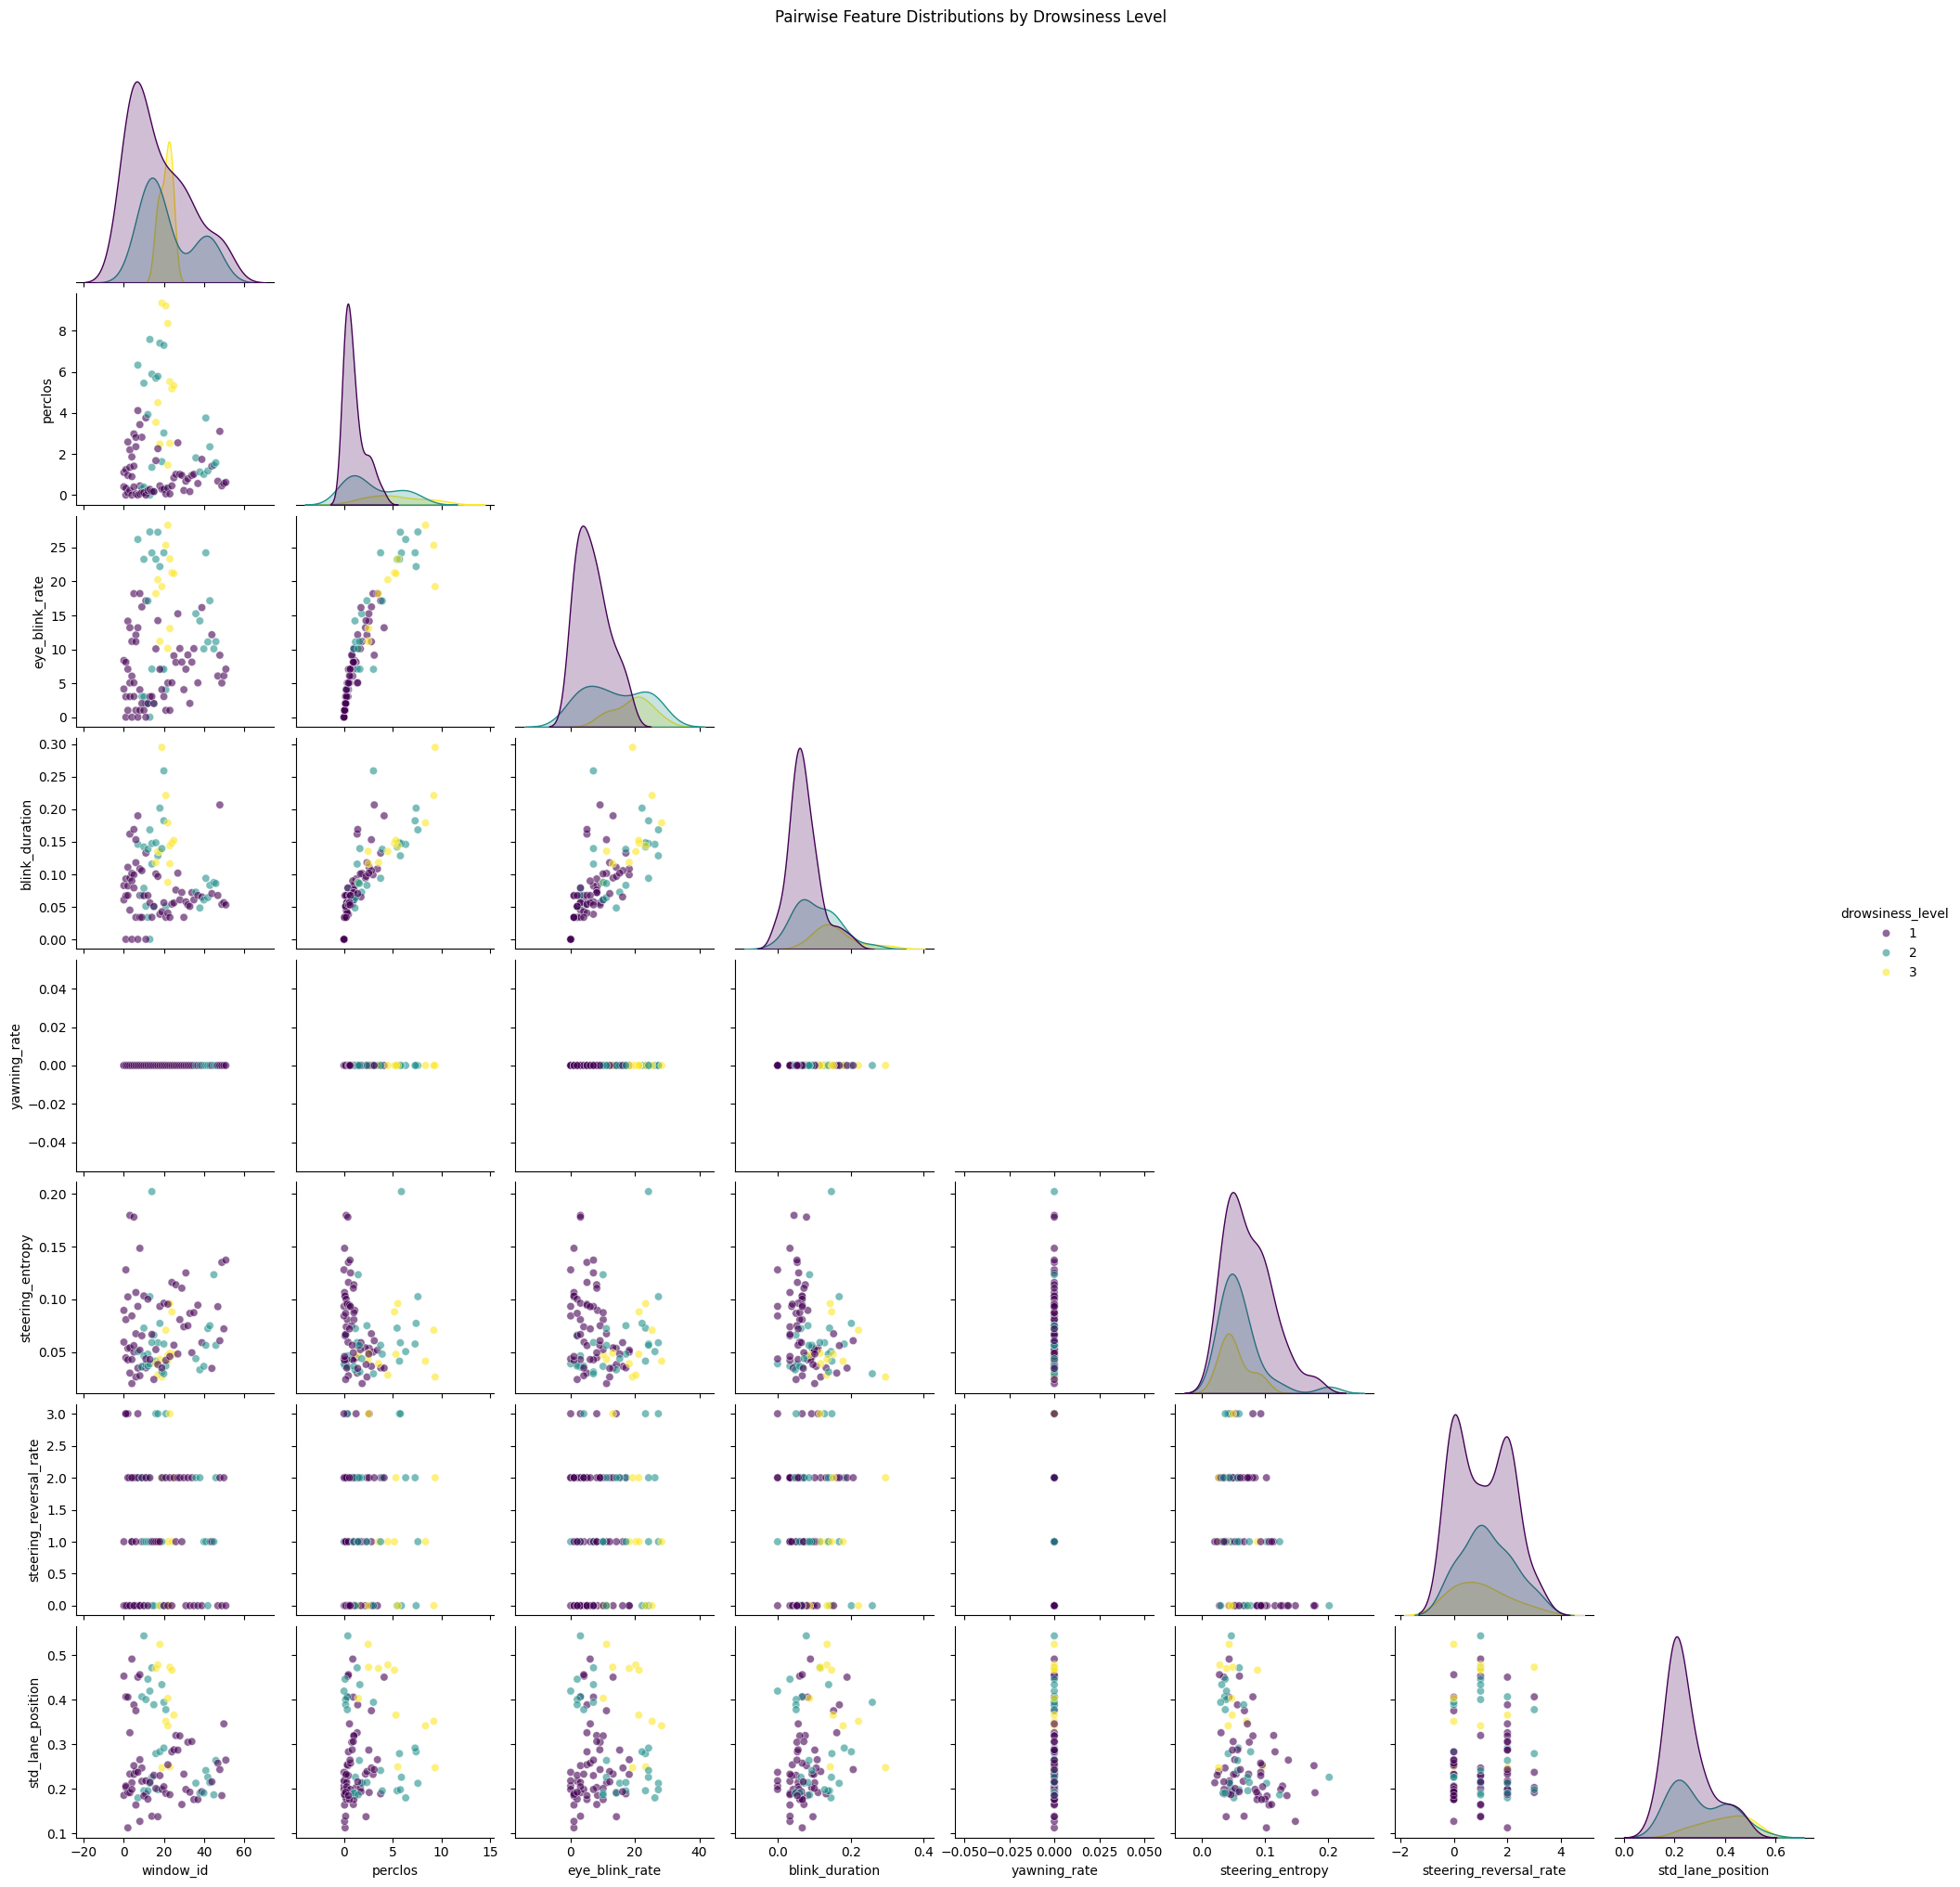

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

feature_cols = ['window_id', 'perclos', 'eye_blink_rate', 'blink_duration',
       'yawning_rate', 'steering_entropy', 'steering_reversal_rate',
       'std_lane_position']
target_col = 'drowsiness_level'


sns.pairplot(df, vars=feature_cols, hue=target_col, corner=True, plot_kws={'alpha':0.6}, palette="viridis")
plt.suptitle("Pairwise Feature Distributions by Drowsiness Level", y=1.02)
plt.show()
